In [89]:
import sys
sys.path.append('./../Quality/')
from Quality import compute_overlap_array

import pickle
import itertools
import numpy as np
from scipy.misc import imresize
from skimage.measure import label
from matplotlib import pyplot as plt
from skimage.filters import threshold_otsu
from skimage.measure import block_reduce as pool

In [26]:
cutouts = pickle.load(open('downsample_mean_collman15.pkl', 'rb'))

In [27]:
def compute_pairwise_vol_cov(vol1, vol2, local_shape):
    e1 = pool(vol1, local_shape, np.mean)
    e2 = pool(vol2, local_shape, np.mean)
    
    s1 = pool(vol1, local_shape, np.std)
    s2 = pool(vol2, local_shape, np.std)
    
    e12 = pool(np.log(np.exp(vol1)+np.exp(vol2)), local_shape, np.mean)
    
    cov = e12 - np.log(np.exp(e1) + np.exp(e2))
    
    return cov

In [28]:
def z_transform(img):
    sigma = np.std(img)
    mu = np.average(img)
    return (img - mu)/sigma

In [35]:
def get_mag_cov_map(chans, selem):
    
    combs = itertools.combinations(chans, 2)
    
    channelMaps = []
    
    for achan, bchan in combs:
        
        #get pairwise intensities
        intMap = np.add(np.stack([z_transform(elem) for elem in cutouts[achan]]),
                        np.stack([z_transform(elem) for elem in cutouts[bchan]]))
        
        intMap = np.nan_to_num(intMap)
       
        #get pairwise covariances
        covMap = compute_pairwise_vol_cov(np.stack([z_transform(elem) for elem in cutouts[achan]]),
                                          np.stack([z_transform(elem) for elem in cutouts[bchan]]),
                                          selem)
        
        #post-process covariance map
        covMap = np.nan_to_num(covMap)
        covMap = np.stack([imresize(elem, intMap[0].shape, interp='nearest') for elem in covMap])
        zUpsampleFactor = intMap.shape[0]//covMap.shape[0]
        zUpsampleOffset = intMap.shape[0]%covMap.shape[0]
        toStack = []
        for i in range(covMap.shape[0]):
            for j in range(zUpsampleFactor):
                toStack.append(covMap[i])
        for i in range(zUpsampleOffset):
                toStack.append(covMap[-1])
        interpCovMap = np.stack(toStack)
        interpCovMap = interpCovMap/np.max(interpCovMap)
       
        #channelmap is intensity  * cov
        channelMap = intMap * interpCovMap
        channelMaps.append(channelMap)
       
    featureMap = np.sum(channelMaps, axis=0)
    
    return featureMap

In [36]:
input_chans = [elem for elem in cutouts.keys()\
               if not 'annot' in elem and not 'EM' in elem]

In [37]:
featureMap = get_mag_cov_map(input_chans, (3, 5, 5))

/home/bstadt/Neurodata/nomadenv/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [38]:
featureMap.shape

(20, 125, 175)

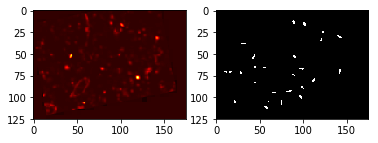

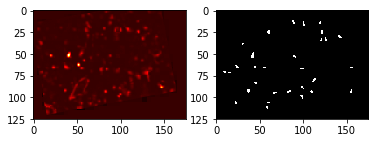

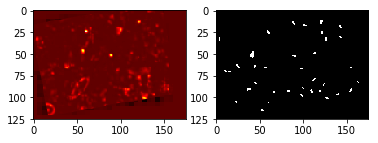

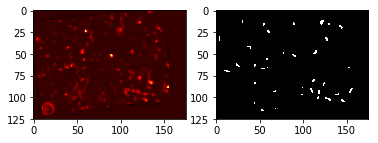

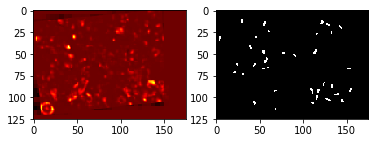

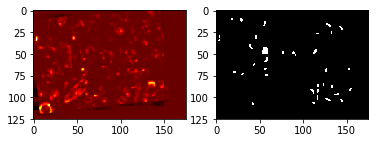

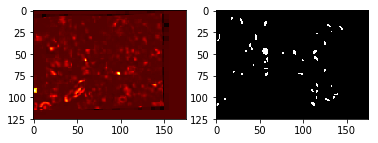

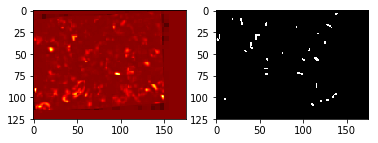

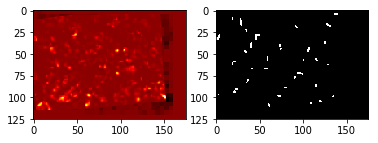

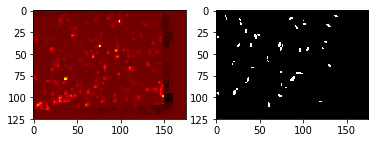

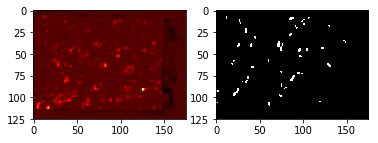

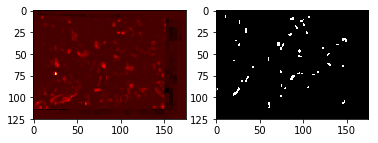

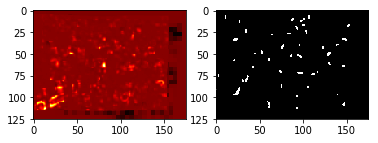

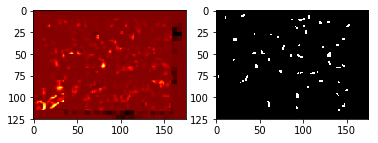

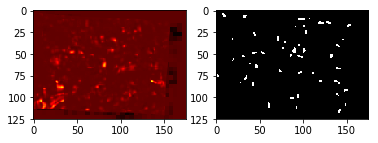

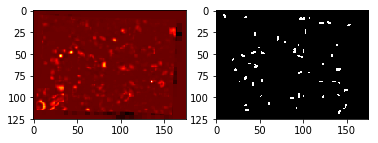

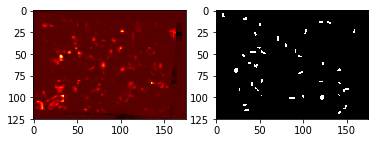

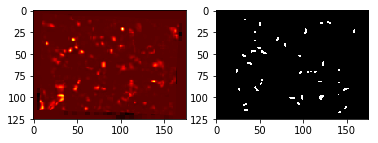

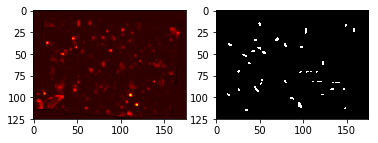

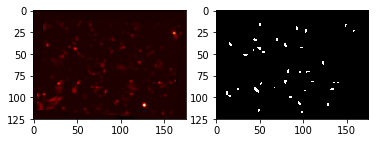

In [43]:
for z in range(featureMap.shape[0]):
    plt.figure()

    plt.subplot(121)
    plt.imshow(featureMap[z], cmap='hot')
    
    plt.subplot(122)
    plt.imshow(cutouts['annotation'][z] > 0, cmap='gray')
    
    plt.show()

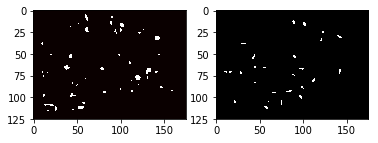

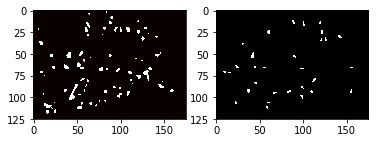

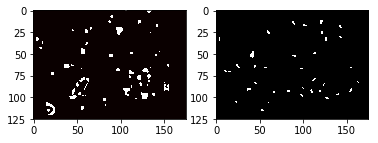

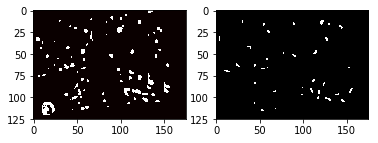

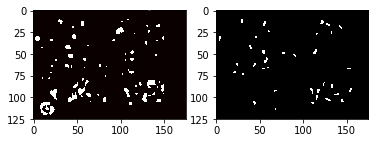

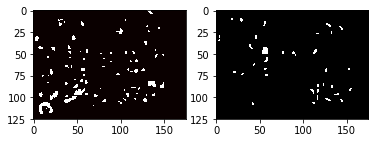

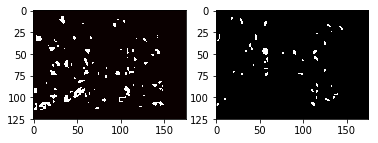

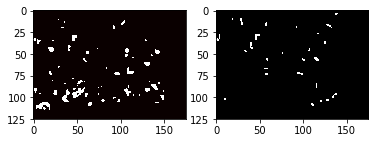

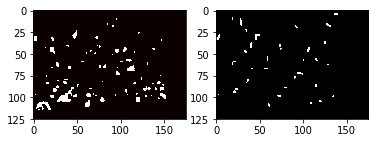

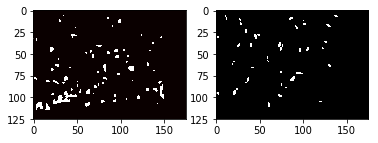

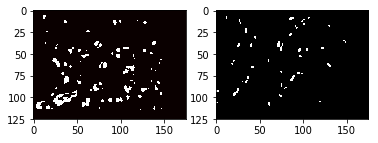

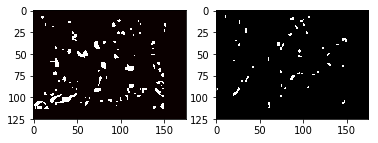

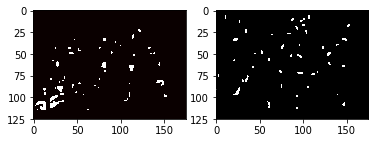

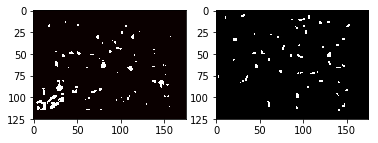

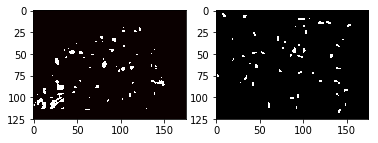

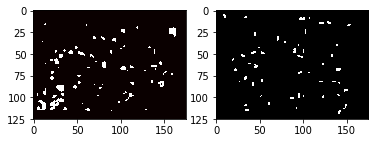

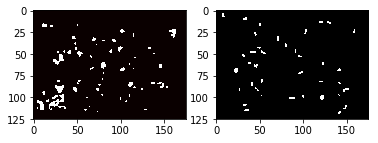

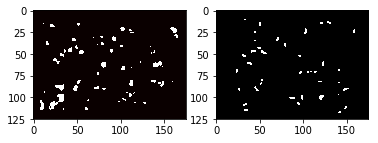

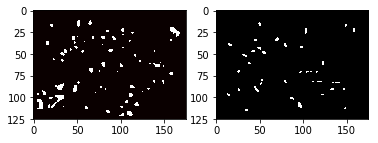

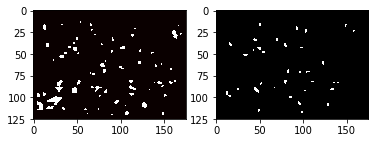

In [49]:
for z in range(featureMap.shape[0]):
    plt.figure()

    plt.subplot(121)
    plt.imshow(featureMap[z] > threshold_otsu(featureMap[z]), cmap='hot')
    
    plt.subplot(122)
    plt.imshow(cutouts['annotation'][z] > 0, cmap='gray')
    
    plt.show()

In [1]:
def summarize(pred):
    gt = np.stack(cutouts['annotation'])
    overlap = compute_overlap_array(pred, gt)
    
    plt.figure()
    plt.title('Prediction Per Gt')

    ax = plt.subplot(111)
    arr = np.array(overlap['predictionPerGt'])
    freq = [np.sum([arr == 0]),
            np.sum([arr == 1]),
            np.sum([arr >= 2])]

    plt.bar([0, 1, 2], freq)
    ax.set_xticks([0, 1, 2])
    plt.show()
    
    plt.figure()
    plt.title('Gt Per Prediction')

    ax = plt.subplot(111)
    arr = np.array(overlap['gtPerPrediction'])
    freq = [np.sum([arr == 0]),
            np.sum([arr == 1]),
            np.sum([arr >= 2])]

    plt.bar([0, 1, 2], freq)
    ax.set_xticks([0, 1, 2])
    plt.show()

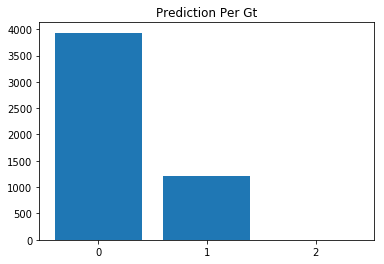

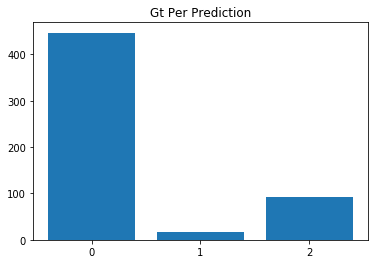

In [88]:
predictions = np.stack([elem > threshold_otsu(elem) for elem in featureMap])
summarize(predictions)